<a href="https://colab.research.google.com/github/miguelsndc/IP/blob/main/Projeto_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')


In [4]:
# ============================================================
# 1. CARREGAR E PREPARAR OS DADOS
# ============================================================

# Carregue o arquivo yeast.data
# Se estiver no Colab, faça upload do arquivo ou use:
# from google.colab import files
# uploaded = files.upload()

# Ler o dataset (sem cabeçalho, separado por espaços)
column_names = ['sequence_name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class']
df = pd.read_csv('yeast.data', sep='\\s+', names=column_names, header=None)

print("Dataset Yeast carregado!")
print(f"Shape: {df.shape}")
print(f"\nPrimeiras linhas:")
print(df.head())
print(f"\nDistribuição das classes:")
print(df['class'].value_counts())

# Remover a coluna de nome da sequência (não é feature)
X = df.drop(['sequence_name', 'class'], axis=1)
y = df['class']

# Codificar as classes
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nNúmero de features: {X.shape[1]}")
print(f"Número de classes: {len(np.unique(y_encoded))}")

Dataset Yeast carregado!
Shape: (1484, 10)

Primeiras linhas:
  sequence_name   mcg   gvh   alm   mit  erl  pox   vac   nuc class
0    ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22   MIT
1    ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22   MIT
2    ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22   MIT
3    AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22   NUC
4    AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22   MIT

Distribuição das classes:
class
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: count, dtype: int64

Número de features: 8
Número de classes: 10


In [5]:
# ============================================================
# 2. DIVISÃO ESTRATIFICADA DOS DADOS (70% treino, 30% teste)
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nConjunto de treino: {X_train.shape[0]} amostras")
print(f"Conjunto de teste: {X_test.shape[0]} amostras")



Conjunto de treino: 1038 amostras
Conjunto de teste: 446 amostras


In [6]:
# ============================================================
# 3. DEFINIR OS CLASSIFICADORES E HIPERPARÂMETROS
# ============================================================

# Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário com os classificadores e seus hiperparâmetros
classifiers = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'saga']
        }
    },
    'K-Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

In [7]:
# ============================================================
# 4. TREINAR E OTIMIZAR CADA CLASSIFICADOR
# ============================================================

results = {}

print("\n" + "="*60)
print("TREINAMENTO E OTIMIZAÇÃO DOS CLASSIFICADORES")
print("="*60)

for name, clf_info in classifiers.items():
    print(f"\n{name}...")

    # Grid Search com validação cruzada
    grid_search = GridSearchCV(
        clf_info['model'],
        clf_info['params'],
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )

    # Treinar
    grid_search.fit(X_train_scaled, y_train)

    # Melhor modelo
    best_model = grid_search.best_estimator_

    # Predições
    y_pred = best_model.predict(X_test_scaled)

    # Métricas
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'predictions': y_pred
    }

    print(f"  Melhores hiperparâmetros: {grid_search.best_params_}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")


TREINAMENTO E OTIMIZAÇÃO DOS CLASSIFICADORES

Decision Tree...
  Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
  Precision: 0.5133
  Recall: 0.5314
  F1-Score: 0.5191
  Accuracy: 0.5314

Naive Bayes...
  Melhores hiperparâmetros: {'var_smoothing': 1e-06}
  Precision: 0.4525
  Recall: 0.1928
  F1-Score: 0.2220
  Accuracy: 0.1928

Logistic Regression...
  Melhores hiperparâmetros: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
  Precision: 0.5933
  Recall: 0.5964
  F1-Score: 0.5836
  Accuracy: 0.5964

K-Neighbors...
  Melhores hiperparâmetros: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
  Precision: 0.6055
  Recall: 0.6121
  F1-Score: 0.6002
  Accuracy: 0.6121

Random Forest...
  Melhores hiperparâmetros: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
  Precision: 0.6116
  Recall: 0.6233
  F1-Score: 0.6116
  Accuracy: 0.6233



COMPARAÇÃO DOS CLASSIFICADORES
         Classifier  Precision   Recall  F1-Score  Accuracy
      Decision Tree   0.513279 0.531390  0.519084  0.531390
        Naive Bayes   0.452453 0.192825  0.221976  0.192825
Logistic Regression   0.593266 0.596413  0.583557  0.596413
        K-Neighbors   0.605516 0.612108  0.600216  0.612108
      Random Forest   0.611588 0.623318  0.611636  0.623318


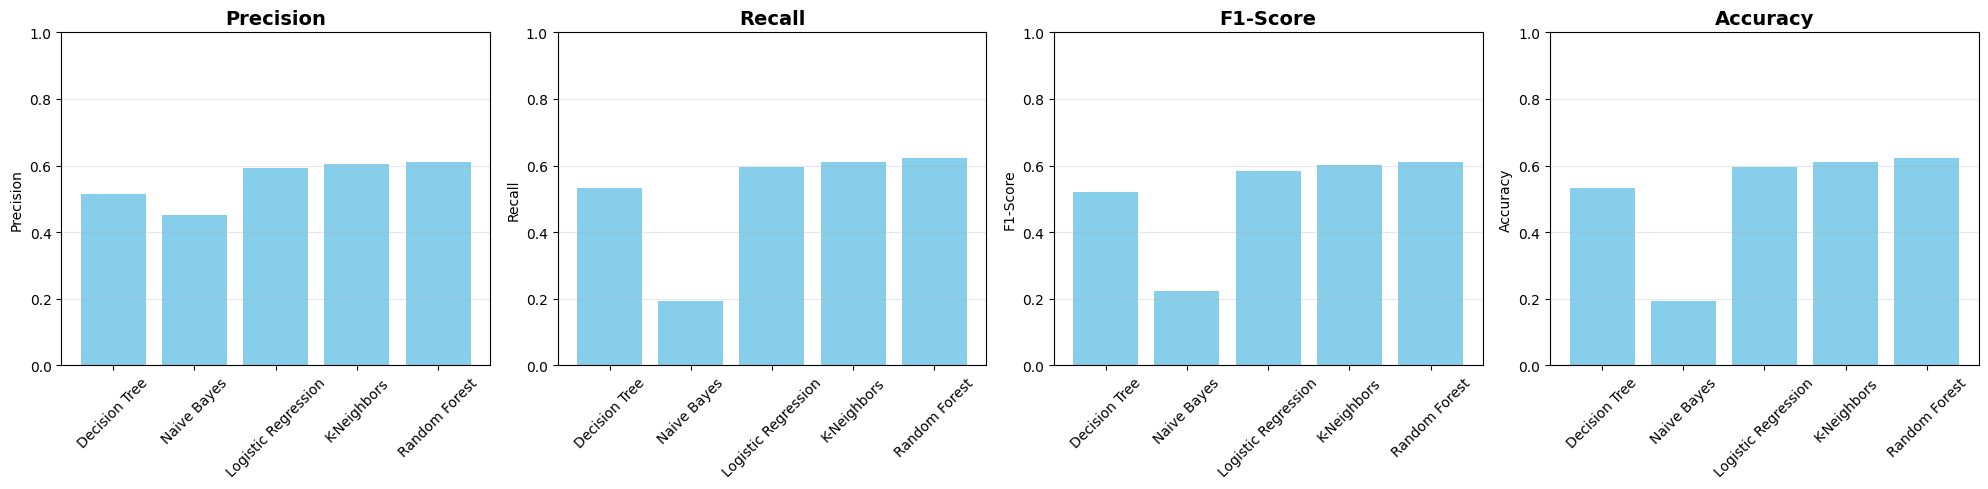

In [8]:
# ============================================================
# 5. COMPARAÇÃO DOS RESULTADOS
# ============================================================

print("\n" + "="*60)
print("COMPARAÇÃO DOS CLASSIFICADORES")
print("="*60)

comparison_df = pd.DataFrame({
    'Classifier': list(results.keys()),
    'Precision': [results[k]['precision'] for k in results.keys()],
    'Recall': [results[k]['recall'] for k in results.keys()],
    'F1-Score': [results[k]['f1'] for k in results.keys()],
    'Accuracy': [results[k]['accuracy'] for k in results.keys()]
})

print(comparison_df.to_string(index=False))

# Visualização
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison_df['Classifier'], comparison_df[metric], color='skyblue')
    axes[idx].set_title(f'{metric}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].set_ylim([0, 1])
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# 6. CURVAS DE APRENDIZAGEM
# ============================================================

print("\n" + "="*60)
print("GERANDO CURVAS DE APRENDIZAGEM")
print("="*60)

# Tamanhos de treino de 5% a 95% com passo de 5%
train_sizes = np.arange(0.05, 1.0, 0.05)

learning_curves = {name: {'train_precision': [], 'test_precision': [],
                          'train_recall': [], 'test_recall': [],
                          'train_f1': [], 'test_f1': [],
                          'train_sizes': []}
                   for name in results.keys()}

for train_size in train_sizes:
    test_size = 1 - train_size

    # Divisão estratificada
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )

    # Normalizar
    scaler_temp = StandardScaler()
    X_tr_scaled = scaler_temp.fit_transform(X_tr)
    X_te_scaled = scaler_temp.transform(X_te)

    for name in results.keys():
        # Treinar o modelo com os melhores hiperparâmetros
        model = results[name]['model']
        model.fit(X_tr_scaled, y_tr)

        # Predições no treino e teste
        y_tr_pred = model.predict(X_tr_scaled)
        y_te_pred = model.predict(X_te_scaled)

        # Métricas
        learning_curves[name]['train_precision'].append(
            precision_score(y_tr, y_tr_pred, average='weighted', zero_division=0))
        learning_curves[name]['test_precision'].append(
            precision_score(y_te, y_te_pred, average='weighted', zero_division=0))
        learning_curves[name]['train_recall'].append(
            recall_score(y_tr, y_tr_pred, average='weighted', zero_division=0))
        learning_curves[name]['test_recall'].append(
            recall_score(y_te, y_te_pred, average='weighted', zero_division=0))
        learning_curves[name]['train_f1'].append(
            f1_score(y_tr, y_tr_pred, average='weighted', zero_division=0))
        learning_curves[name]['test_f1'].append(
            f1_score(y_te, y_te_pred, average='weighted', zero_division=0))
        learning_curves[name]['train_sizes'].append(train_size * 100)

print("Curvas de aprendizagem calculadas!")


GERANDO CURVAS DE APRENDIZAGEM
Curvas de aprendizagem calculadas!


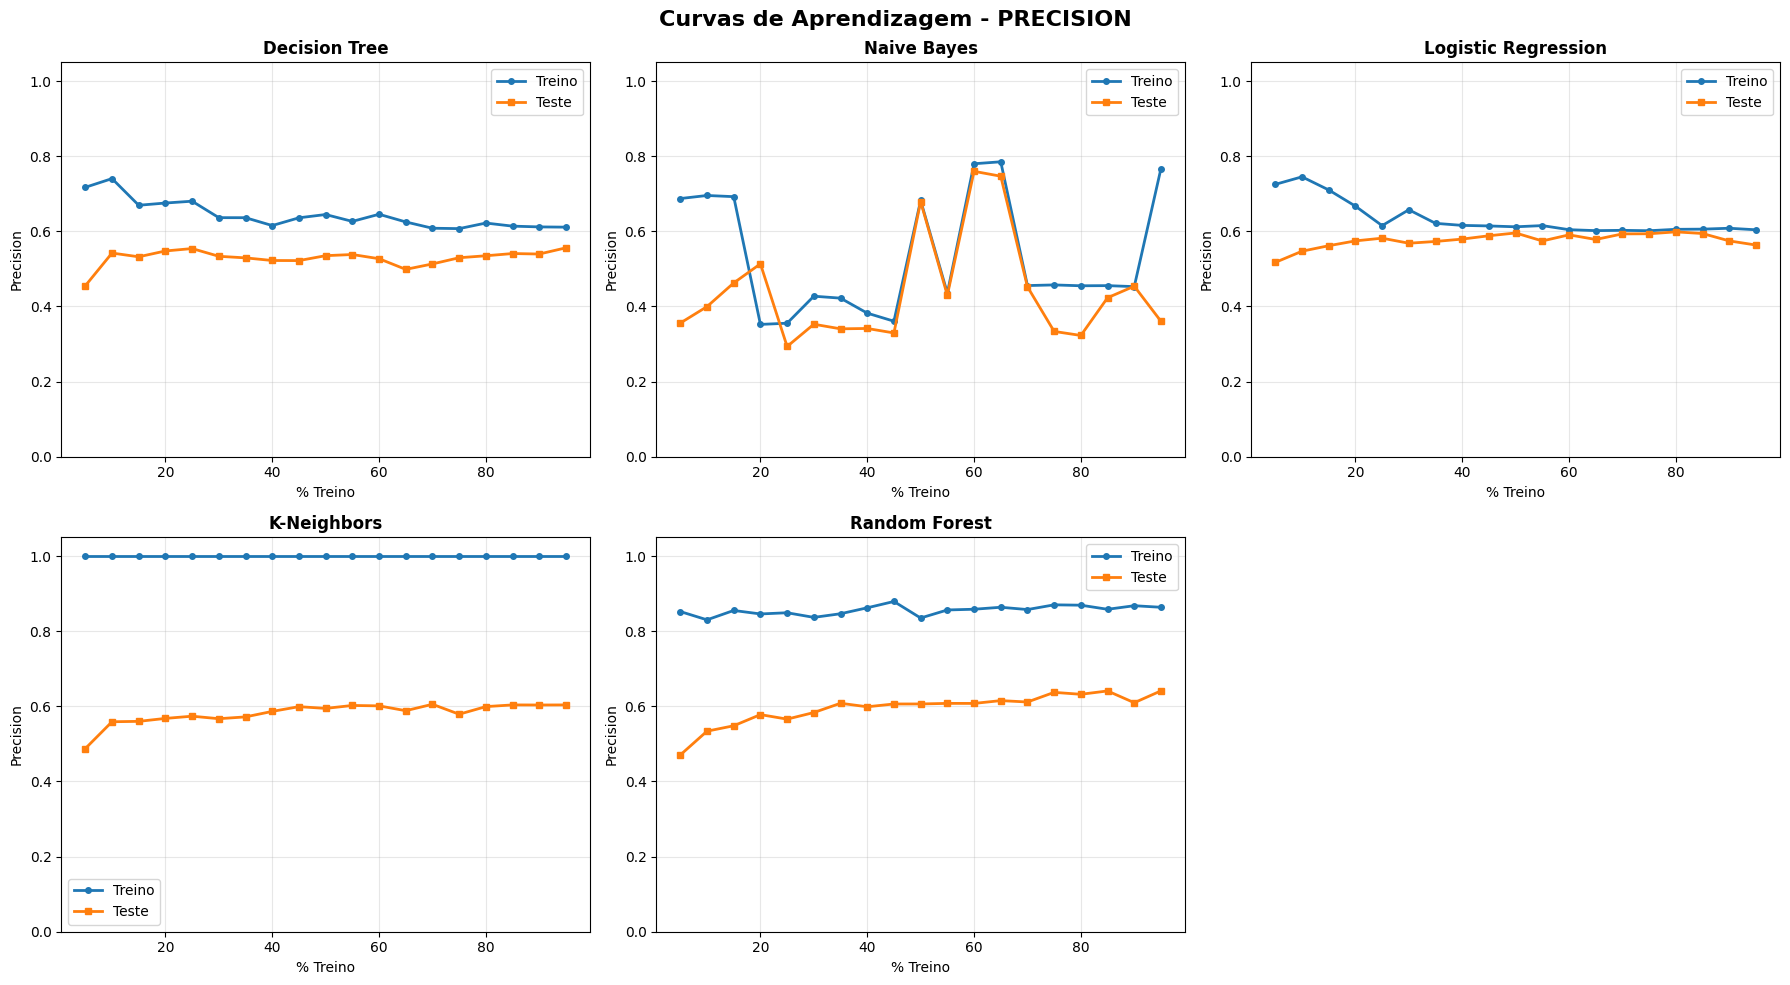

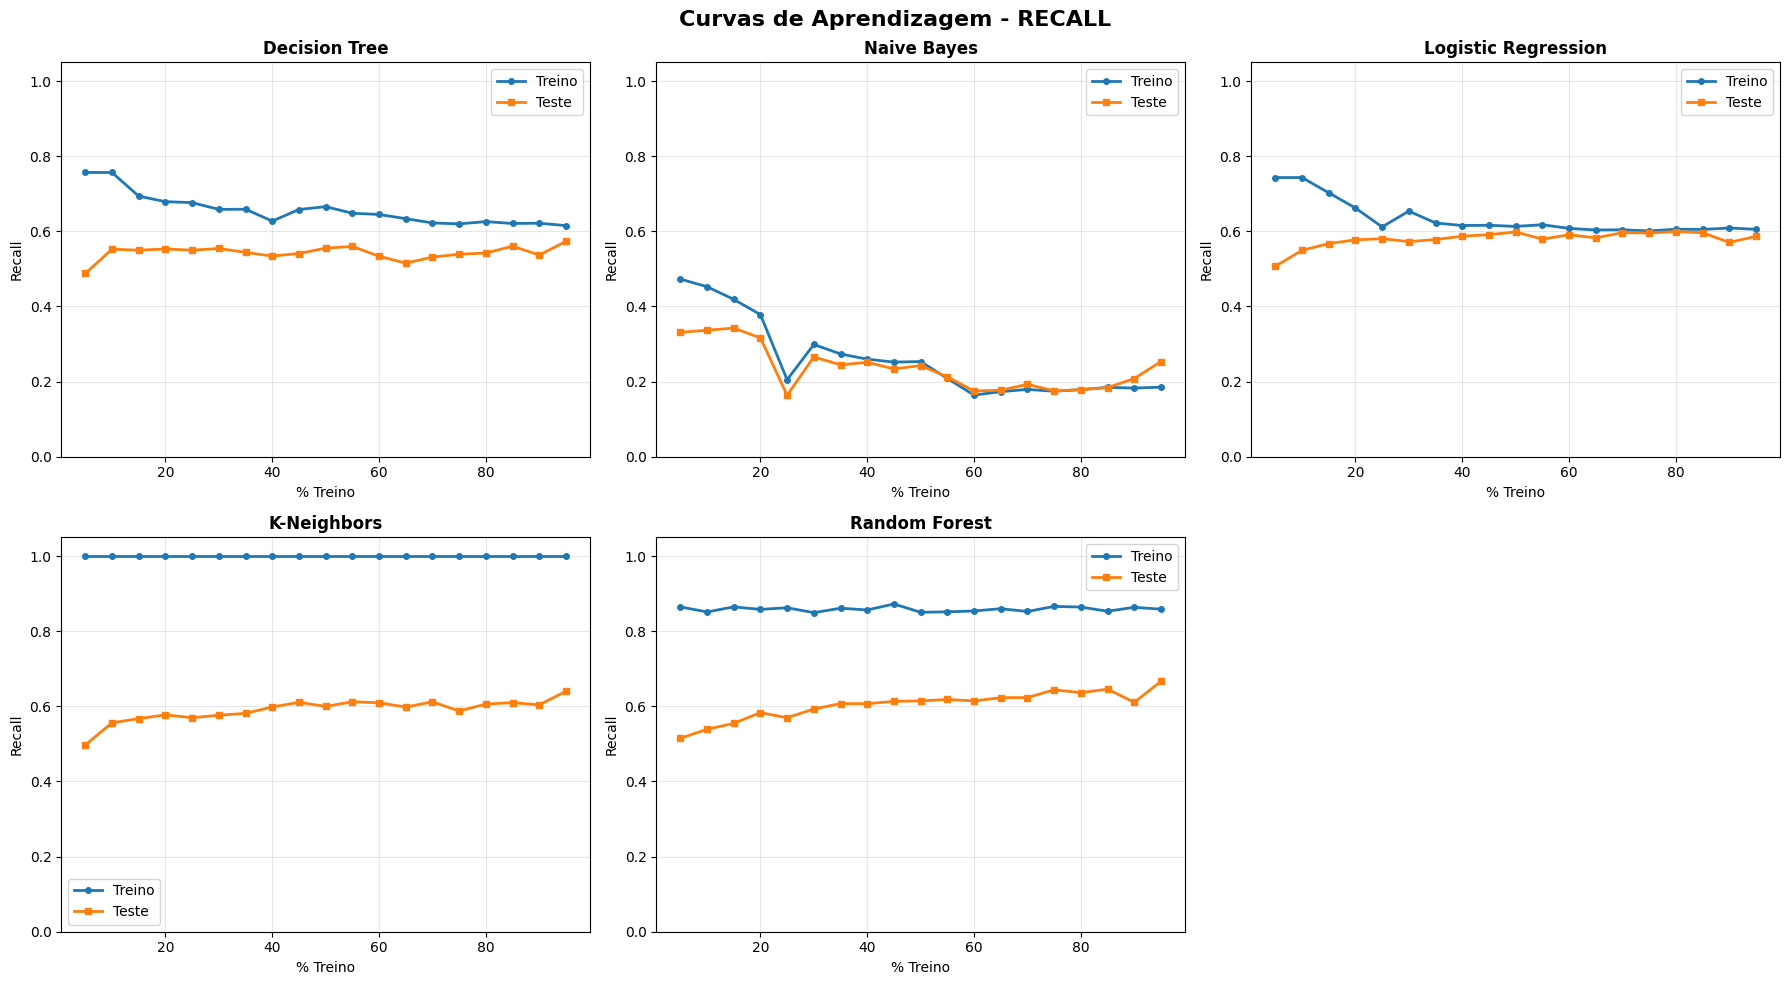

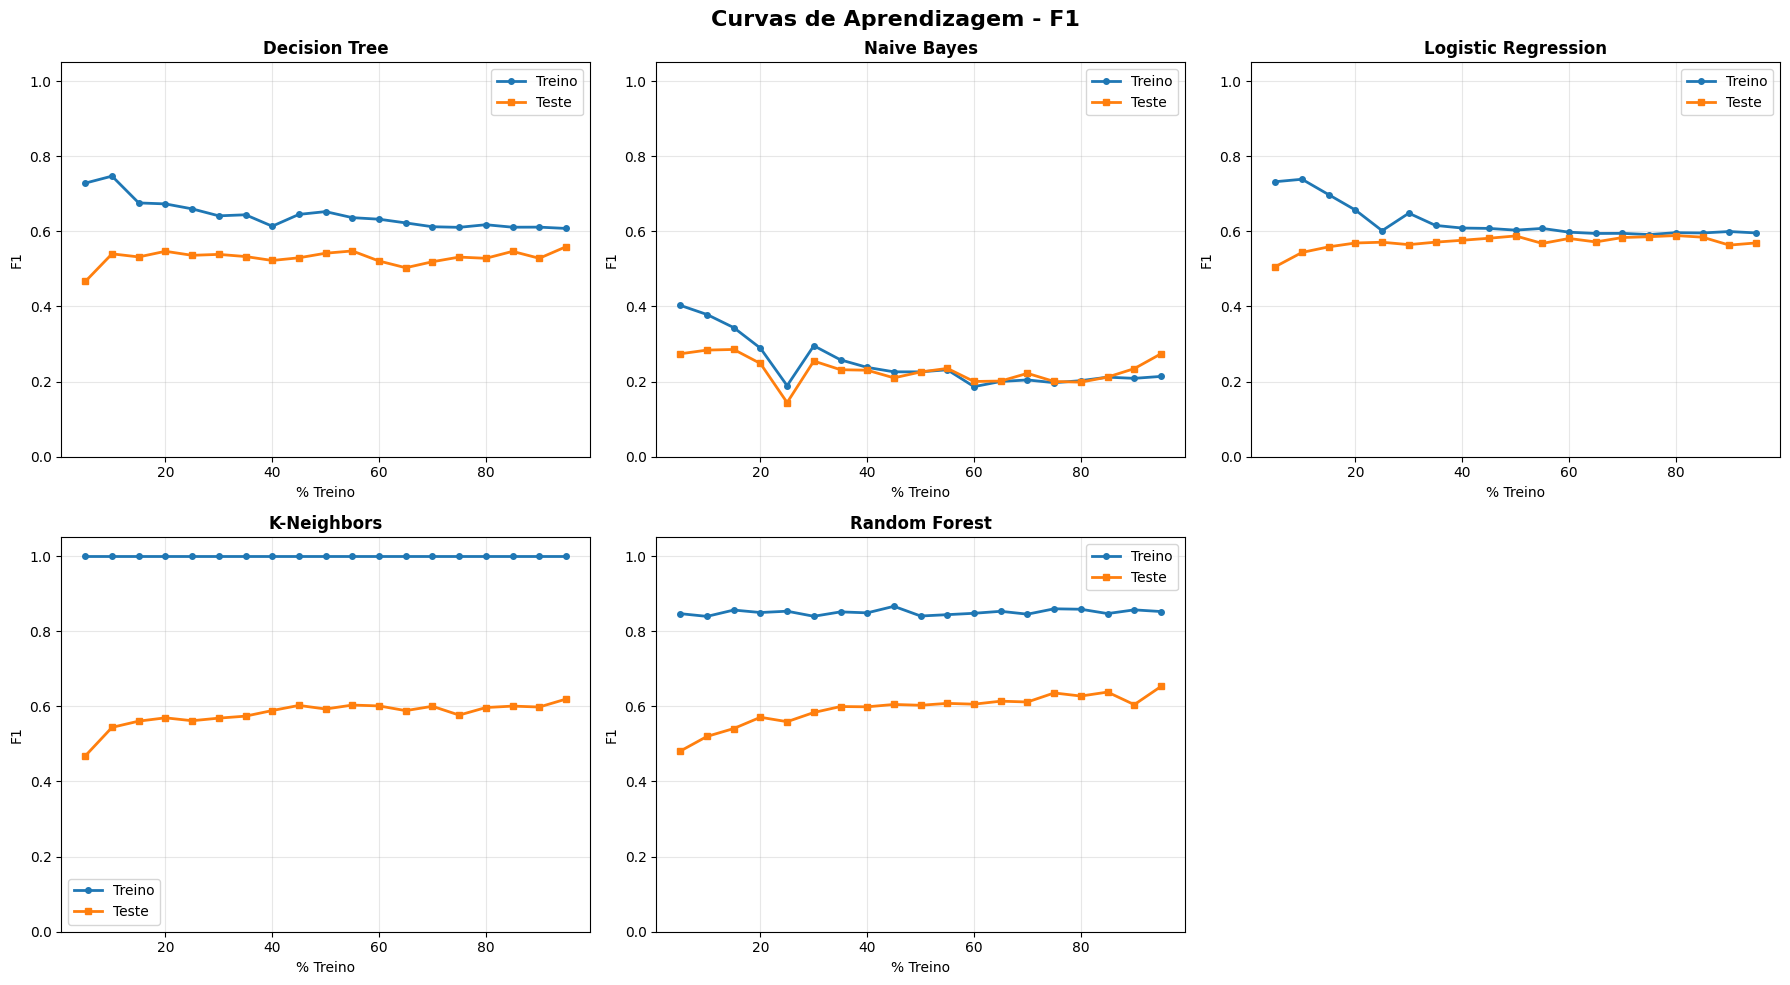

In [10]:
# ============================================================
# 7. PLOTAR CURVAS DE APRENDIZAGEM
# ============================================================

metrics_to_plot = ['precision', 'recall', 'f1']

for metric in metrics_to_plot:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Curvas de Aprendizagem - {metric.upper()}', fontsize=16, fontweight='bold')

    for idx, name in enumerate(results.keys()):
        row = idx // 3
        col = idx % 3

        ax = axes[row, col]

        train_key = f'train_{metric}'
        test_key = f'test_{metric}'

        ax.plot(learning_curves[name]['train_sizes'],
                learning_curves[name][train_key],
                'o-', label='Treino', linewidth=2, markersize=4)
        ax.plot(learning_curves[name]['train_sizes'],
                learning_curves[name][test_key],
                's-', label='Teste', linewidth=2, markersize=4)

        ax.set_xlabel('% Treino', fontsize=10)
        ax.set_ylabel(metric.capitalize(), fontsize=10)
        ax.set_title(name, fontsize=12, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1.05])

    # Remover subplot extra se houver
    if len(results.keys()) < 6:
        fig.delaxes(axes[1, 2])

    plt.tight_layout()
    plt.show()

In [11]:
# ============================================================
# 8. ANÁLISE E COMENTÁRIOS
# ============================================================

print("\n" + "="*60)
print("ANÁLISE DOS RESULTADOS")
print("="*60)

print("\n1. DESEMPENHO DOS CLASSIFICADORES:")
best_f1 = max(results.items(), key=lambda x: x[1]['f1'])
print(f"   - Melhor F1-Score: {best_f1[0]} ({best_f1[1]['f1']:.4f})")

best_precision = max(results.items(), key=lambda x: x[1]['precision'])
print(f"   - Melhor Precision: {best_precision[0]} ({best_precision[1]['precision']:.4f})")

best_recall = max(results.items(), key=lambda x: x[1]['recall'])
print(f"   - Melhor Recall: {best_recall[0]} ({best_recall[1]['recall']:.4f})")

print("\n2. OBSERVAÇÕES DAS CURVAS DE APRENDIZAGEM:")
print("   - Overfitting: ocorre quando a curva de treino está muito acima da de teste")
print("   - Underfitting: ocorre quando ambas as curvas estão baixas")
print("   - Bom ajuste: curvas próximas e em valores altos")
print("   - Com mais dados de treino, o desempenho no teste tende a melhorar")

print("\n3. MELHORES HIPERPARÂMETROS POR CLASSIFICADOR:")
for name, result in results.items():
    print(f"   {name}:")
    for param, value in result['best_params'].items():
        print(f"     - {param}: {value}")

print("\n" + "="*60)
print("ANÁLISE COMPLETA!")
print("="*60)


ANÁLISE DOS RESULTADOS

1. DESEMPENHO DOS CLASSIFICADORES:
   - Melhor F1-Score: Random Forest (0.6116)
   - Melhor Precision: Random Forest (0.6116)
   - Melhor Recall: Random Forest (0.6233)

2. OBSERVAÇÕES DAS CURVAS DE APRENDIZAGEM:
   - Overfitting: ocorre quando a curva de treino está muito acima da de teste
   - Underfitting: ocorre quando ambas as curvas estão baixas
   - Bom ajuste: curvas próximas e em valores altos
   - Com mais dados de treino, o desempenho no teste tende a melhorar

3. MELHORES HIPERPARÂMETROS POR CLASSIFICADOR:
   Decision Tree:
     - criterion: entropy
     - max_depth: 5
     - min_samples_leaf: 2
     - min_samples_split: 10
   Naive Bayes:
     - var_smoothing: 1e-06
   Logistic Regression:
     - C: 100
     - penalty: l2
     - solver: lbfgs
   K-Neighbors:
     - metric: euclidean
     - n_neighbors: 15
     - weights: distance
   Random Forest:
     - max_depth: 30
     - min_samples_leaf: 1
     - min_samples_split: 10
     - n_estimators: 200
